### Library import

In [4]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading


import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,3)

import data_read

In [ ]:
from PyQt5.QtWidgets import *
from PyQt5.QtCore import *
from PyQt5.QtGui import *

matplotlib.use("Qt5Agg")
from matplotlib.figure import Figure
from matplotlib.animation import TimedAnimation
from matplotlib.lines import Line2D
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas

### Data capture using serial port

In [ ]:
ser = serial.Serial('/dev/ttyACM0', baudrate=115200)
ser.flushInput()
result = [] # Array to store readed values
n = 4096 # Number of values to read. Each arduino read is 2048bytes.
for i in range(n):
    line = ser.readline() # Read serial port input
    if line:
        string = line.decode() # Decode values
        result.append(string.split('\r')[0]) # Split and save only the valuable data

        with open("captured_data/test.csv", "a") as f: # Save data to local file
            writer = csv.writer(f, delimiter=',')
            writer.writerow([string])
#Remove empty values and convert to float
if '' in result:
    result.remove('')
result = [float(i_res) for i_res in result]

ser.close()

### Data reading from storage file

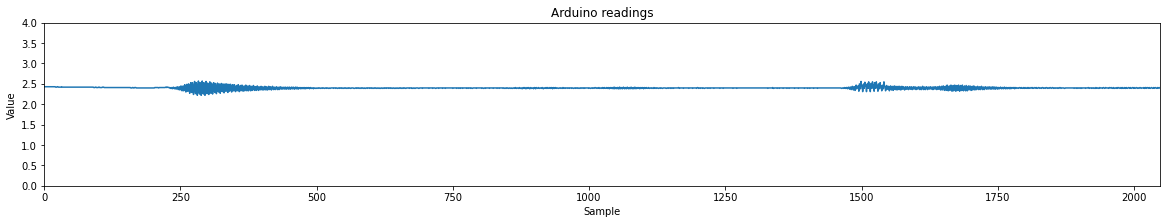

In [57]:
df = pd.read_csv('captured_data/test.csv', header=None, dtype={'Voltages': float}) #read csv file
df = df.replace('\r\n', '', regex = True)
df.drop(df[df[0].str.len() != 4].index, inplace=True)
#df.drop(df[df[0] == ''].index, inplace=True)

x = df[0].to_numpy().astype(float)
y = np.arange(0, len(x))

plt.plot(y, x)
plt.title('Arduino readings')
plt.ylim([0, 4])
plt.xlim([0,2048])
plt.xlabel('Sample')
plt.ylabel('Value')
plt.show()

### Real Time Data reading and plot via Serial Port

In [ ]:
app = QApplication(sys.argv)
QApplication.setStyle(QStyleFactory.create('Plastique'))
myGUI = data_read.CustomMainWindow()
sys.exit(app.exec_())

### Data cleaning and transformation

In [ ]:

##KALMAN FILTER TEST
R = 10
H = 1.00
Q = 10
P = 0
U_hat = 0
K = 0


def kalman_filter(U):
    
    R = 40
    H = 1.00
    Q = 1e-5
    P = 0
    U_hat = 0
    K = 10
    
    for element in U:
        K = P*H/(H*P*H+R)
        U_hat += K*(U-H*U_hat)
        P = (1-K*H)*P+Q
    
    return(U_hat)

print(sample)
print(kalman_filter(sample))

ax_x = sample
ax_y = np.arange(0, len(sample))

plt.subplot(2,1,1)

plt.plot(ax_y, ax_x, label = "Without filtering")
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")

plt.legend()

plt.subplot(2,1,2)
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")
plt.legend()
plt.show()

In [ ]:
init_val = 2048
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]

kalman = kalman_filter(sample)

plt.plot(ax_y, kalman, label = "Kalman")

sample = (np.exp(sample - sample.mean())-1)*30

ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
#plt.plot(ax_y, ax_x, label = "Without filtering")

#Mean filter
i = 0
for n_sample in sample:
    
    if i == 0:
        sample[i] = (sample[i] + sample[i+1] )/2
    elif i == len(sample)-1:
        sample[i] = (sample[i] + sample[i-1])/2
    else:
        sample[i] = (sample[i-1] + sample[i] + sample [i+1] )/ 3
    
    i+=1

ax_x = sample*2
#plt.plot(ax_y, ax_x, label = "With filtering")

plt.legend(loc = "lower right")
plt.show()

In [ ]:
''' This part is intended to amplify the raw signal from R8 resistor. 
This is signal is the input of a comparator. A vcc/2 signal is used to compare.
So our signal is shifted 2.5V, therefore we need to substract that value to read more correctly the values from the ADC
'''
init_val = 2048
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]

sample = np.exp(sample - sample.mean())**10

ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x, label = "Without filtering")

#Mean filter
i = 0
for n_sample in sample:
    
    if i == 0:
        sample[i] = (sample[i] + sample[i+1] )/2
    elif i == len(sample)-1:
        sample[i] = (sample[i] + sample[i-1])/2
    else:
        sample[i] = (sample[i-1] + sample[i] + sample [i+1] )/ 3
    
    i+=1

ax_x = sample
#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x, label = "With filtering")

#confidence threshold
threshold_mean = sample.mean()*1.15
confidence_threshold = [threshold_mean for i in range(len(sample))]
plt.plot(ax_y,confidence_threshold, color = 'red')


#echo center
echo_plot_y = [i for i in range(7)]
center_point = echo_center_point(sample)[0]

#pulse center
center_point_pulse = int(echo_center_point(sample)[1])
echo_plot_x = [center_point_pulse for i in range(len(echo_plot_y))]
plt.plot(echo_plot_x, echo_plot_y, label = 'Pulse center point')



for i in range(len(center_point)): 
    echo_plot_x = [center_point[i] for j in range(len(echo_plot_y))]
    plt.plot(echo_plot_x, echo_plot_y, label = 'Echo center point')


plt.legend(loc = "lower right")

print('Pulse center point: ', center_point_pulse)
print('Echo center point: ', center_point)
print('First echo distance: ', echo_distance())


plt.show()

In [ ]:
def echo_center_point(sample):
    sample_mean = sample.mean()
    pulse_window = 10
    overshoot_confidence = 1.15
    echo_values = []
    pulse_values = []
    echo_center = []
    for i in range(len(sample)):
        sample_window = sample[i:i+pulse_window]
        window_mean = sum(sample_window)/len(sample_window)
        if window_mean > sample_mean*overshoot_confidence:
            if i > 500:
                echo_values.append(i)
            else:
                pulse_values.append(i)

    #print(echo_values)
    pulse_center = int(sum(pulse_values)/len(pulse_values))
    pulse_width = int(len(pulse_values)*0.4)
    for i in range(0, round(len(echo_values)/pulse_width)):
        temp_values = echo_values[pulse_width*(i):pulse_width*(i+1)]
        temp_center = sum(temp_values)/len(temp_values) 
        echo_center.append(int(temp_center))
        
    return(echo_center, pulse_center)

echo_center_point(sample)

In [ ]:
def echo_distance():
    #pulse_origin = 300
    threshold_values = center_point[0]-center_point_pulse
    air_speed = 343
    sample_freq = 140000

    distance = (1/sample_freq)*threshold_values*air_speed/2
    
    return(distance)

In [ ]:
init_val = 4096
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]
sample = np.exp(sample - sample.mean())**10
ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x)
plt.show()

In [ ]:
x_portion = x[0:2048]
y_portion = np.arange(0, len(x_portion))

plt.plot(y_portion,
         x_portion,
         label = "Echo Pulse")
plt.plot(y_portion,
         x[16384:18432],
         label = "Raw Analog output")

plt.plot(y_portion,
         x[24576:26624])


plt.title('Arduino readings')
plt.ylim([0, 4])
#plt.xlim([0,8090])
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

threshold_values = len(x_portion[x_portion>3.0])

air_speed = 343
sample_freq = 140000

distance = (1/sample_freq)*threshold_values*air_speed/2
print("Distance: ", distance, "[m]")

In [ ]:
threshold_values = 1250

air_speed = 343
sample_freq = 70000*2

distance = (1/sample_freq)*threshold_values*air_speed/2
print("Distance: ", distance, "[m]")

In [ ]:
x_portion = x[2048:4096]
y_portion = np.arange(0, len(x_portion))

plt.plot(y_portion,
         x_portion,
         label = "Echo Pulse")

plt.title('Arduino readings')
plt.ylim([0, 4])
#plt.xlim([0,8090])
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

threshold_values = len(x_portion[x_portion>2.5])

air_speed = 343
sample_freq = 140000

distance = (1/sample_freq)*threshold_values*air_speed/2
print("Distance: ", distance, "[m]")

In [ ]:
init_val = 6144
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]
sample = np.exp(sample - sample.mean())**2
ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x)
plt.show()